In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tqdm.notebook import tqdm

from spectral_simulator.classes import *
from spectral_simulator.constants import *

### .lis CASSIS File ➔ NumPy Frequency Space

Converts .lis file readable by CASSIS into a frequency space NumPy format for the MCMC script. Set the `INPUT_DATA_PATH` to the location of your `.lis` file and adjust the `OUTPUT_DATA_PATH` for the desired output location of the `.npy` file before running the script.

In [ ]:
def process_ascii(file_path):
    frequencies = []
    intensities = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        # Skip first three lines
        for line in lines[3:]:
            columns = line.split()
            if len(columns) < 5:
                continue  # Skip lines that don't have enough data
            frequency = float(columns[0])
            intensity = float(columns[4])
            frequencies.append(frequency)
            intensities.append(intensity)
    
    return np.array([frequencies, intensities])

# Print frequencies and intensities in two-column format
def print_data_in_columns(data):
    frequencies, intensities = data
    for freq, inten in zip(frequencies, intensities):
        print(f"{freq:.6f}\t{inten:.6f}")

BASE_DIR = os.getcwd()
INPUT_DATA_PATH = "DSN_data/cha_mms1_hc7n_example.lis"
OUTPUT_DATA_PATH = os.path.join(BASE_DIR, 'DSN_data', 'cha_mms1_hc7n_example.npy')

data = process_ascii(INPUT_DATA_PATH)
print_data_in_columns(data)
np.save(OUTPUT_DATA_PATH, data)
print(f"Data saved to {OUTPUT_DATA_PATH}")

### MCMC Sampling Chain ➔ Corner Plot Animation

Create corner plots (scatterplot matrices) at different steps in the chain to show walkers exploring the parameter space and learning distributions, using nonlinear timesteps to highlight early exploration before convergence. Includes different scripts for fixed axes (looking at the full chain to set limits) and free axes (looking at the current chain to iteratively adjust limits). Fixed axes provide a smoother result, but free axes emphasize early exploration.

In [ ]:
matplotlib.rcParams['animation.embed_limit'] = 1000

def animate_corner_fixed_axes(chain_path, save_path, param_labels, ):
    plt.rcParams.update({
        "text.usetex": False,
        "font.family": "DejaVu Sans"
    })

    # Load MCMC chain
    chain = np.load(chain_path)
    burn_in = int(0.2 * chain.shape[1])
    chain = chain[:, burn_in:, :]
    samples = chain.reshape((-1, chain.shape[-1]))

    # Set axis limits using complete sample set
    fig_corner_test = corner.corner(samples, labels=param_labels)
    axes_corner_test = np.array(fig_corner_test.axes).reshape(len(param_labels), len(param_labels))
    axis_limits = [(ax.get_xlim(), ax.get_ylim()) for ax in axes_corner_test.ravel()]
    plt.close(fig_corner_test)

    fig_corner, axes_corner = plt.subplots(len(param_labels), len(param_labels), figsize=(10, 10))

    def update_corner(frame):
        for ax, (xlim, ylim) in zip(axes_corner.ravel(), axis_limits):
            ax.clear()
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
        corner.hist2d_kwargs = {'bins': 50, 'plot_datapoints': True, 'plot_density': True, 'plot_contours': True, 'fill_contours': False, 'show_titles': True, 'title_fmt': '.1e'}
        corner.corner(samples[:frame, :], labels=param_labels, quantiles=[0.16, 0.5, 0.84], title_kwargs={"fontsize": 12}, fig=fig_corner, **corner.hist2d_kwargs)
        return axes_corner.ravel()

    # Emphasis early exploration with nonlinear timesteps (boundary can be adjusted)
    total_samples = len(samples)
    initial_frames = np.geomspace(100, total_samples * 0.2, 100, dtype=int)             # Logarithmic distribution for the first 20%
    remaining_frames = np.linspace(total_samples * 0.2, total_samples, 200, dtype=int)  # Linear distribution for the remaining 80%
    frames_corner = np.unique(np.concatenate((initial_frames, remaining_frames)))

    ani_corner = FuncAnimation(fig_corner, update_corner, frames=tqdm(frames_corner), blit=False, interval=33)  # Millisecond interval for ~30 FPS
    display(HTML(ani_corner.to_jshtml()))
    if save_path:
        ani_corner.save(save_path, writer='pillow', fps=30)  # 30 FPS for output file

animate_corner_fixed_axes(
    chain_path='./DSN_fit_results/hc5n_hfs/chain.npy',  # Change input path...
    save_path='C2_HC5N_AUG7_corner.gif',      # and an optional output path for saving
    param_labels=['Source Size [″]', 'Ncol [cm⁻²]', 'Tex [K]', 'vlsr [km s⁻¹]', 'dV [km s⁻¹]'],
)

In [ ]:
matplotlib.rcParams['animation.embed_limit'] = 1000

def animate_corner_free_axes(chain_path, save_path, param_labels):
    plt.rcParams.update({
        "text.usetex": False,
        "font.family": "DejaVu Sans"
    })

    # Load MCMC chain
    chain = np.load(chain_path)
    burn_in = int(0.2 * chain.shape[1])
    chain = chain[:, burn_in:, :]
    samples = chain.reshape((-1, chain.shape[-1]))

    fig_corner, axes_corner = plt.subplots(len(param_labels), len(param_labels), figsize=(10, 10))

    def update_corner(frame):
        for ax in axes_corner.ravel():
            ax.clear()
        corner.hist2d_kwargs = {'bins': 50, 'plot_datapoints': True, 'plot_density': True, 'plot_contours': True, 'fill_contours': False, 'show_titles': True, 'title_fmt': '.1e'}
        corner.corner(samples[:frame, :], labels=param_labels, quantiles=[0.16, 0.5, 0.84], title_kwargs={"fontsize": 12}, fig=fig_corner, **corner.hist2d_kwargs)
        return axes_corner.ravel()

    # Emphasis early exploration with nonlinear timesteps (boundary can be adjusted)
    total_samples = len(samples)
    initial_frames = np.geomspace(100, total_samples * 0.2, 100, dtype=int)             # Logarithmic distribution for the first 20%
    remaining_frames = np.linspace(total_samples * 0.2, total_samples, 200, dtype=int)  # Linear distribution for the remaining 80%
    frames_corner = np.unique(np.concatenate((initial_frames, remaining_frames)))

    ani_corner = FuncAnimation(fig_corner, update_corner, frames=tqdm(frames_corner), blit=False, interval=33)  # Millisecond interval for ~30 FPS
    display(HTML(ani_corner.to_jshtml()))
    if save_path:
        ani_corner.save(save_path, writer='pillow', fps=30)  # 30 FPS for output file

animate_corner_free_axes(
    chain_path='./DSN_fit_results/hc5n_hfs/chain_template.npy',  # Change input path...
    save_path='C2_HC5N_3AUG8_corner.gif',      # and an optional output path for saving
    param_labels=['Source Size', 'Ncol', 'Tex', 'vlsr', 'dV'],
)

### MCMC Sampling Chain ➔ Custom Corner Plots

Generates custom, high-resolution corner plots (scatterplot matrices) from MCMC chains. In the context of free parameters used in these MCMC scripts, column densities ($N_{col}$) are typically rendered in scientific notation using the format $(\text{median} \pm _{\text{lower uncertainty}}^{\text{upper uncertainty}}) \times 10^{\text{exponent}}$, while other parameters like $\text{Source Size}$, $T_{ex}$, $v_{\text{LSR}}$, and $\Delta V$ are displayed in regular number formatting. Includes an optional parameter to generate trace plots.

The main function resides in the `spectral_simulator/functions`, and is called in `MCMC_inference`, but can also be customized here on chain data for specific analysis.

In [ ]:
# Generate custom corner (scatterplot matrices), trace (time-series) plots, and table of best-fit values
def plot_results(chain_path, param_labels, velocity_components=1, include_trace=False):
    if velocity_components == 4:
        param_labels_latex = [
            r'Source Size$_1$ [$^{\prime\prime}$]', r'Source Size$_2$ [$^{\prime\prime}$]', 
            r'Source Size$_3$ [$^{\prime\prime}$]', r'Source Size$_4$ [$^{\prime\prime}$]', 
            r'N$_{\mathrm{col}_1}$ [cm$^{-2}$]', r'N$_{\mathrm{col}_2}$ [cm$^{-2}$]', 
            r'N$_{\mathrm{col}_3}$ [cm$^{-2}$]', r'N$_{\mathrm{col}_4}$ [cm$^{-2}$]', 
            r'T$_{\mathrm{ex}}$ [K]', r'v$_{\mathrm{lsr}_1}$ [km s$^{-1}$]', 
            r'v$_{\mathrm{lsr}_2}$ [km s$^{-1}$]', r'v$_{\mathrm{lsr}_3}$ [km s$^{-1}$]', 
            r'v$_{\mathrm{lsr}_4}$ [km s$^{-1}$]', r'dV [km s$^{-1}$]'
        ]
    elif velocity_components == 1:
        param_labels_latex = [
            r'Source Size [$^{\prime\prime}$]', r'N$_{\mathrm{col}}$ [cm$^{-2}$]', 
            r'T$_{\mathrm{ex}}$ [K]', r'v$_{\mathrm{lsr}}$ [km s$^{-1}$]', r'dV [km s$^{-1}$]'
        ]
        
    else:
        print(f"{RED}Error: Parameter labels haven't been added for this number of velocity components.{RESET}")
        return
    
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.size": 12
    })
    
    # Load the MCMC chain
    chain = np.load(chain_path)
    burn_in = int(0.2 * chain.shape[1])
    chain = chain[:, burn_in:, :]
    
    # Reshape the chain to (nwalkers*nsteps, ndim)
    samples = chain.reshape((-1, chain.shape[-1]))
    
    # Custom title formatter for corner plot
    def custom_title_formatter(param_index):
        mcmc = np.percentile(samples[:, param_index], [16, 50, 84])
        q = np.diff(mcmc)
        value = mcmc[1]
        lower = q[0]
        upper = q[1]
        
        if abs(value) < 1e-3 or abs(value) > 1e3:
            base_str = f"{value / 10**np.floor(np.log10(value)):.2f}"
            lower_str = f"{lower / 10**np.floor(np.log10(value)):.2f}"
            upper_str = f"{upper / 10**np.floor(np.log10(value)):.2f}"
            exponent = int(np.floor(np.log10(value)))
            value_str = f"({base_str}_{{-{lower_str}}}^{{+{upper_str}}}) \\times 10^{{{exponent}}}"
        else:
            value_str = f"{value:.2f}"
            lower_str = f"{lower:.2f}"
            upper_str = f"{upper:.2f}"
            value_str = f"{value_str}^{{+{upper_str}}}_{{-{lower_str}}}"
        
        return f"${value_str}$"
    
    # Generate corner plot
    fig = corner.corner(samples, labels=param_labels_latex, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12})
    axes = np.array(fig.axes).reshape((len(param_labels_latex), len(param_labels_latex)))
    
    for i in range(len(param_labels_latex)):
        title = custom_title_formatter(i)
        axes[i, i].set_title(f"{param_labels_latex[i]}: {title}", fontsize=12)
    
    fig.savefig(f"{chain_path[:-4]}_corner.png", dpi=600)

    # Generate trace plots
    if include_trace:
        n_params = len(param_labels)  # Number of parameters to plot
        fig, axes = plt.subplots(nrows=n_params, figsize=(10, 2 * n_params))
        if n_params == 1:
            axes = [axes]  # Make it iterable if only one parameter
        for i, ax in enumerate(axes):
            ax.plot(chain[:, :, i].T, color="k", alpha=0.3)
            ax.set_title(f'Parameter {i+1}: {param_labels_latex[i]}')
            ax.set_xlabel("Step Number")
        plt.tight_layout()
        fig.savefig(f"{chain_path[:-4]}_trace.png")

### Velocity space in ASCII format $\rightarrow$ frequency space in NumPy format

Converts DSN `.spec` files, which are labeled by the J quantum number and include rest frequencies, from velocity space to frequency space. Replace the file paths in the `spectra` list with the paths to your own `.spec` files. Verify that the rest frequencies (in MHz) are correctly specified for each transition. 

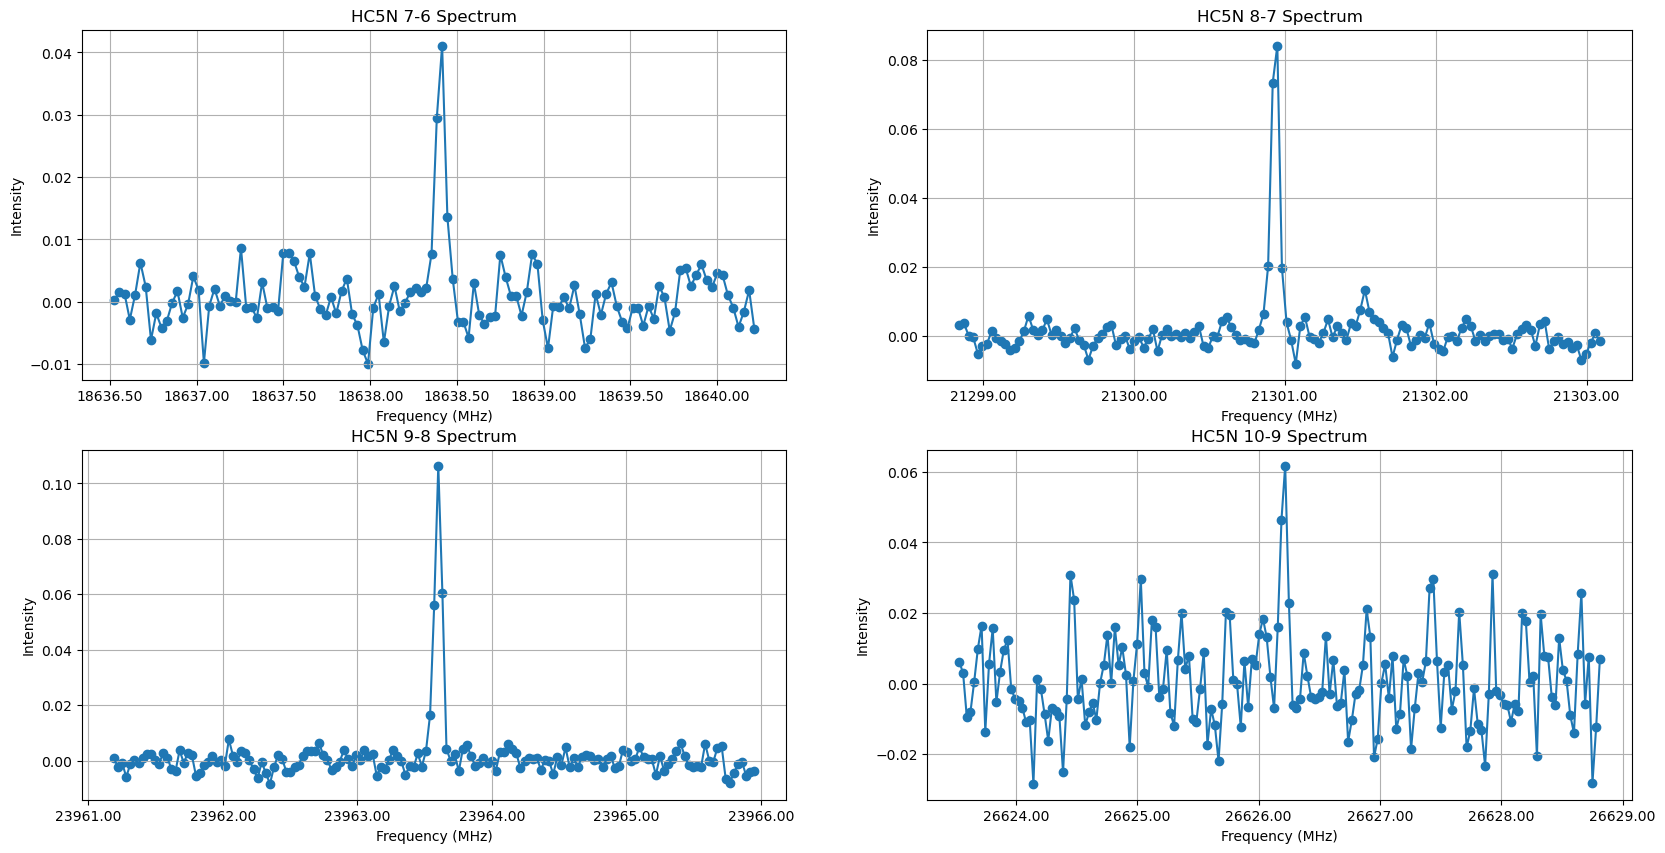

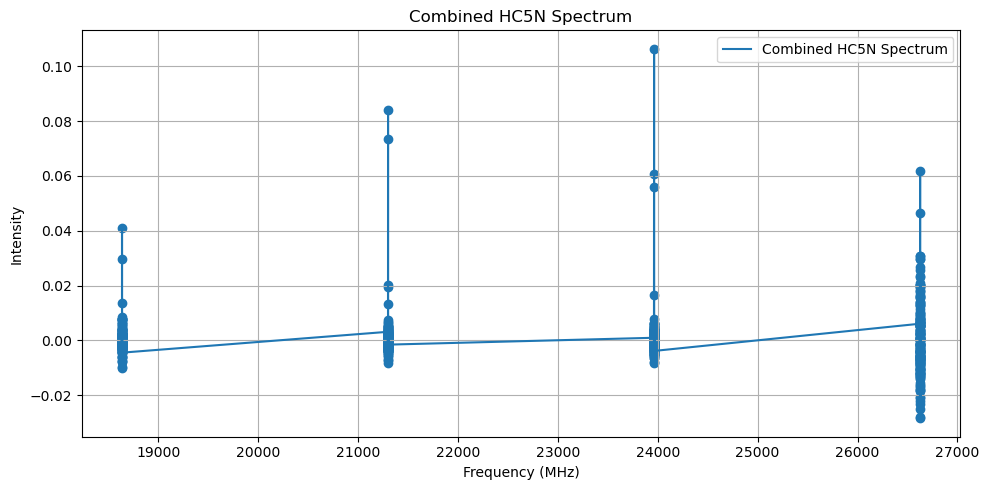

In [3]:
# Parse ASCII format DSN observations
def process_file(filepath, rest_frequency):
    with open(filepath, "r") as f:
        content = f.readlines()

    data = []
    for line in content:
        if line.strip():  # Skip empty lines
            parsed_line = list(map(float, line.split()))
            data.append(parsed_line)

    velocities, intensities = np.array(data).T
    frequencies = velocity_to_frequency(velocities, rest_frequency)

    return frequencies, intensities

def velocity_to_frequency(velocity, rest_frequency):
    c = 299792.458
    frequency_shift = (velocity / c) * rest_frequency
    frequencies = rest_frequency - frequency_shift
    return frequencies

# Currently set up for template species HC5N...
def plot_spectrum(frequencies, intensities, label, ax):
    ax.scatter(frequencies, intensities, label=f'HC5N {label}')
    ax.plot(frequencies, intensities)
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax.set_title(f'HC5N {label} Spectrum')
    ax.set_xlabel('Frequency (MHz)')
    ax.set_ylabel('Intensity')
    ax.grid(True)

fig, axes = plt.subplots(2, 2, figsize=(20, 10)) 
axes = axes.flatten()

spectra = [
    ("DSN_data/CHA-C2-HC5N7-6_1.86386164E+04.spec", 18638.6164, '7-6'),
    ("DSN_data/CHA-C2-HC5N8-7_2.13012614E+04.spec", 21301.2614, '8-7'),
    ("DSN_data/CHA-C2-HC5N9-8_2.39639007E+04.spec", 23963.9007, '9-8'),
    ("DSN_data/CHA-C2-HC5N10-9_2.6626543E+04.spec", 26626.543, '10-9')
]

all_frequencies = []
all_intensities = []

for i, (path, freq, label) in enumerate(spectra):
    frequencies, intensities = process_file(path, freq)
    plot_spectrum(frequencies, intensities, label, axes[i])
    all_frequencies.extend(frequencies)
    all_intensities.extend(intensities)

BASE_DIR = os.getcwd()
DATA_PATH = os.path.join(BASE_DIR, 'DSN_data', 'C2_hc5n_hfs_chunks.npy')

np.save(DATA_PATH, np.array([all_frequencies, all_intensities]))
print(f"Data saved to {DATA_PATH}")

fig_combined, ax_combined = plt.subplots(figsize=(10, 5))
ax_combined.plot(all_frequencies, all_intensities, label='Combined HC5N Spectrum')
ax_combined.scatter(all_frequencies, all_intensities)
ax_combined.set_title('Combined HC5N Spectrum')
ax_combined.set_xlabel('Frequency (MHz)')
ax_combined.set_ylabel('Intensity')
ax_combined.legend()
ax_combined.grid(True)

plt.tight_layout()
plt.show()

### Frequency space in ASCII format $\rightarrow$ frequency space in NumPy format

Converts DSN `.spec` files, which are labeled by the J quantum number and include rest frequencies. Replace the file paths in the `filepaths` list with the paths to your own `.spec` files. 

In [ ]:
def process_ascii(filepath):
    with open(filepath, "r") as f:
        content = f.readlines()

    data = []
    for line in content:
        if line.strip():  # Skip empty lines
            parsed_line = list(map(float, line.split()))
            data.append(parsed_line)

    frequencies, intensities, _, _ = np.array(data).T

    return frequencies, intensities

filepaths = [
    "./DSN_data/CHA-MMS1-HC5N10-9.spec",
    "./DSN_data/CHA-MMS1-HC5N9-8.spec",
    "./DSN_data/CHA-MMS1-HC5N8-7.spec",
    "./DSN_data/CHA-MMS1-HC5N7-6.spec"
]

all_frequencies = []
all_intensities = []

for filepath in filepaths[::-1]: 
    freq, intensity = process_ascii(filepath)
    all_frequencies.extend(freq)
    all_intensities.extend(intensity)

plt.plot(all_frequencies, all_intensities)
plt.scatter(all_frequencies, all_intensities)
plt.show()

BASE_DIR = os.getcwd()
DATA_PATH = os.path.join(BASE_DIR, 'DSN_data', 'MMS1_hc5n_hfs_chunks.npy')
np.save(DATA_PATH, np.array([all_frequencies, all_intensities]))

print(f"Data saved to {DATA_PATH}")